# Calibrage de la caméra

In [10]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

## Renommer les fichiers 
Pour plus de clarté

In [49]:
import os

# Chemin du dossier contenant les images
folder_path = "../data/reconstruction"

# Lister tous les fichiers dans le dossier
files = os.listdir(folder_path)

# Filtrer uniquement les fichiers image (par extension)
image_extensions = {".jpg", ".png", ".jpeg"}  # Ajouter d'autres extensions si nécessaire
images = [f for f in files if os.path.splitext(f)[1].lower() in image_extensions]

# Renommer les fichiers
for i, file_name in enumerate(sorted(images)):
    # Nouveau nom (par exemple : calib_1.jpg, calib_2.jpg, etc.)
    new_name = f"reconstruction_{i+1}{os.path.splitext(file_name)[1]}"
    
    # Chemin complet avant et après
    old_path = os.path.join(folder_path, file_name)
    new_path = os.path.join(folder_path, new_name)
    
    # Renommer le fichier
    os.rename(old_path, new_path)
    print(f"Renommé : {file_name} -> {new_name}")

print("Renommage terminé.")


Renommé : 473660867_1130596035275189_2068216611032222764_n.jpg -> reconstruction_1.jpg
Renommé : 473663314_8089062911196676_3062704453195810352_n.jpg -> reconstruction_2.jpg
Renommé : 473711192_2082804728841000_2892553323946829459_n.jpg -> reconstruction_3.jpg
Renommé : 473732591_1825446841531004_8570862925369830371_n.jpg -> reconstruction_4.jpg
Renommé : 473745451_1690379625218917_5877536116425879571_n.jpg -> reconstruction_5.jpg
Renommé : 473781972_1318244122557118_9030115558180721191_n.jpg -> reconstruction_6.jpg
Renommé : 473994804_574477238736772_209744302494003740_n.jpg -> reconstruction_7.jpg
Renommé : 474005516_624499423366243_768542134605350309_n.jpg -> reconstruction_8.jpg
Renommé : 474073013_1159892305705482_4844481310602369068_n.jpg -> reconstruction_9.jpg
Renommé : 474242170_933036568937377_2307554544186385063_n.jpg -> reconstruction_10.jpg
Renommé : 474330713_1606225330285463_3020909484028901103_n.jpg -> reconstruction_11.jpg
Renommé : 474492332_1171922311023063_814460654

## Calibration

In [22]:

folder_path = "../data/calibration"
# Dimensions de l'échiquier (nombre de coins internes par ligne et colonne)
nx, ny = 7, 7

# Préparer les points 3D (coordonnées réelles dans l'espace 3D)
objp = np.zeros((nx * ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

obj_points = []  # Points 3D réels
img_points = []  # Points 2D détectés

# Charger les images pour le calibrage
images = [os.path.join(folder_path, f"calib_{i}.jpg") for i in range(1,18) if i!= 11 ]
print (len(images))
for fname in images:
    img = cv2.imread(fname)

    if img is None:
        print(f"Image non chargée : {fname}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    seuil = gray>170
    grayscale_seuil = (seuil.astype(np.uint8)) * 255
    # Trouver les coins de l'échiquier
    ret, corners = cv2.findChessboardCorners(grayscale_seuil, (nx, ny), None)
    print(ret)
    if ret :
        obj_points.append(objp)
        img_points.append(corners)

        # Afficher les coins détectés
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        print(f"Traitement de {fname}: Coins détectés: {ret}")
        cv2.imshow('Corners', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()


16
True
Traitement de ../data/calibration\calib_1.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_2.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_3.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_4.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_5.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_6.jpg: Coins détectés: True
False
True
Traitement de ../data/calibration\calib_8.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_9.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_10.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_12.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_13.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_14.jpg: Coins détectés: True
True
Traitement de ../data/calibration\calib_15.jpg: Coins détectés: True
False
True
Traitement de ../data/cali

In [21]:
# Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

# Affichage des résultats
print("Matrice intrinsèque:\n", mtx)
print("Coefficients de distorsion:\n", dist)

# Enregistrer les paramètres
np.savez("calibration_data.npz", mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

Matrice intrinsèque:
 [[907.78724198   0.         313.44998458]
 [  0.         891.91974182 339.86315858]
 [  0.           0.           1.        ]]
Coefficients de distorsion:
 [[-0.7811829   2.66886672 -0.00795355  0.00687002 -3.86904047]]


## Détermination de la rotation et de la translation entre deux images

In [26]:
# Charger les deux images
img1 = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(images[1], cv2.IMREAD_GRAYSCALE)

# Détecter les points d'intérêt et les descripteurs avec ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Associer les descripteurs avec BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)  # Norme Hamming pour ORB
matches = bf.match(des1, des2)

# Trier les correspondances par distance (meilleures correspondances en premier)
matches = sorted(matches, key=lambda x: x.distance)

# Dessiner les correspondances
matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Afficher les images avec les correspondances
cv2.imshow("Correspondances", matched_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [25]:
# Dessiner les points d'intérêt sur les images
img1_with_keypoints = cv2.drawKeypoints(img1, kp1, None, color=(0, 255, 0), flags=0)
img2_with_keypoints = cv2.drawKeypoints(img2, kp2, None, color=(0, 255, 0), flags=0)

# Afficher les images avec les points d'intérêt
cv2.imshow("Image 1 - Points d'intérêt", img1_with_keypoints)
cv2.imshow("Image 2 - Points d'intérêt", img2_with_keypoints)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Reconstruction

### ORB

In [58]:
import cv2

# Charger les images
images = [cv2.imread(f"../data/reconstruction/reconstruction_{i+1}.jpg", cv2.IMREAD_GRAYSCALE) for i in range(1, 14)]

for i, img in enumerate(images):
    if img is None:
        print(f"L'image reconstruction_{i+1}.jpg n'a pas été chargée correctement.")
    else:
        print(f"L'image reconstruction_{i+1}.jpg a été chargée avec succès.")

# Détecteur SIFT
sift = cv2.SIFT_create()

keypoints_list = []
descriptors_list = []
matches_list = []

for img in images:
    kp, des = sift.detectAndCompute(img, None)
    keypoints_list.append(kp)
    descriptors_list.append(des)
    print(f"Image {i+1}: {len(kp)} points clés détectés")

# Associer les points entre paires d'images
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)  # Utiliser NORM_L2 pour SIFT
for i in range(len(images) - 1):
    matches = bf.match(descriptors_list[i], descriptors_list[i + 1])
    matches = sorted(matches, key=lambda x: x.distance)  # Trier par distance
    matches_list.append(matches)
    print(f"Nombre de correspondances entre l'image {i+1} et {i+2}: {len(matches)}")

print(f"Total des paires analysées : {len(matches_list)}")

L'image reconstruction_1.jpg a été chargée avec succès.
L'image reconstruction_2.jpg a été chargée avec succès.
L'image reconstruction_3.jpg a été chargée avec succès.
L'image reconstruction_4.jpg a été chargée avec succès.
L'image reconstruction_5.jpg a été chargée avec succès.
L'image reconstruction_6.jpg a été chargée avec succès.
L'image reconstruction_7.jpg a été chargée avec succès.
L'image reconstruction_8.jpg a été chargée avec succès.
L'image reconstruction_9.jpg a été chargée avec succès.
L'image reconstruction_10.jpg a été chargée avec succès.
L'image reconstruction_11.jpg a été chargée avec succès.
L'image reconstruction_12.jpg a été chargée avec succès.
L'image reconstruction_13.jpg a été chargée avec succès.
Image 13: 1630 points clés détectés
Image 13: 1175 points clés détectés
Image 13: 1626 points clés détectés
Image 13: 1087 points clés détectés
Image 13: 1084 points clés détectés
Image 13: 1812 points clés détectés
Image 13: 747 points clés détectés
Image 13: 1031 po

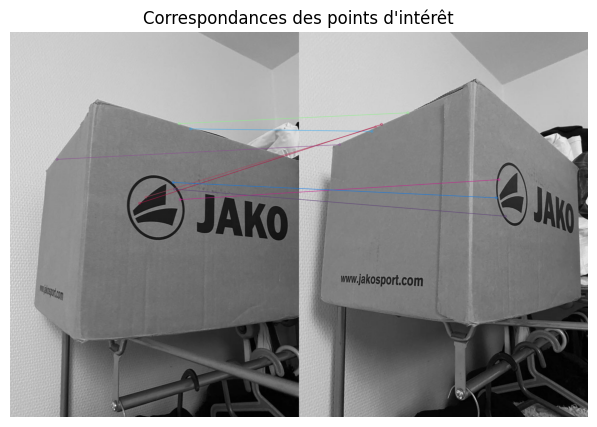

In [59]:
# Exemple : Afficher les correspondances pour la première paire d'images
img1 = images[0]
img2 = images[1]
kp1 = keypoints_list[0]
kp2 = keypoints_list[1]
matches = matches_list[0]  # Correspondances de la première paire

# Dessiner les correspondances sur une image combinée
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:8], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Afficher avec Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(img_matches, cmap='gray')
plt.title("Correspondances des points d'intérêt")
plt.axis('off')
plt.show()

### Estimation de E

In [60]:
rotations = [np.eye(3)]  # Initialiser avec l'identité pour la première image
translations = [np.zeros((3, 1))]

for i, matches in enumerate(matches_list):
    # Obtenir les points correspondants
    pts1 = np.float32([keypoints_list[i][m.queryIdx].pt for m in matches])
    pts2 = np.float32([keypoints_list[i + 1][m.trainIdx].pt for m in matches])

    # Calcul de la matrice essentielle
    E, mask = cv2.findEssentialMat(pts1, pts2, mtx, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    # Récupérer R et t
    _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, mtx)

    # Ajouter les rotations et translations relatives
    rotations.append(rotations[-1] @ R)
    translations.append(translations[-1] + rotations[-1] @ t)

In [61]:
# Triangulation des points pour les paires
points_3D = []

for i, matches in enumerate(matches_list):
    pts1 = np.float32([keypoints_list[i][m.queryIdx].pt for m in matches])
    pts2 = np.float32([keypoints_list[i + 1][m.trainIdx].pt for m in matches])

    # Projections des caméras
    proj1 = np.dot(mtx, np.hstack((rotations[i], translations[i])))
    proj2 = np.dot(mtx, np.hstack((rotations[i + 1], translations[i + 1])))

    # Triangulation
    points4D = cv2.triangulatePoints(proj1, proj2, pts1.T, pts2.T)
    points4D /= points4D[3]  # Homogénéisation
    points_3D.append(points4D[:3].T)  # Ajouter les points 3D


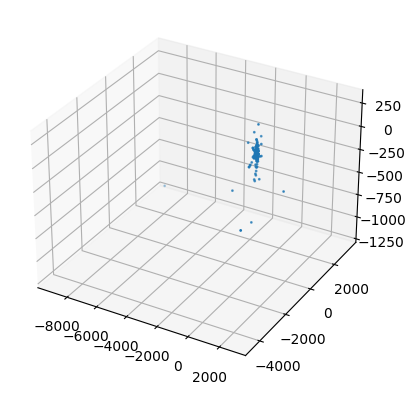

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Empiler tous les points 3D triangulés
all_points_3D = np.vstack(points_3D)
ax.scatter(all_points_3D[:, 0], all_points_3D[:, 1], all_points_3D[:, 2], s=1)

plt.show()


In [57]:
import open3d as o3d

# Charger le nuage de points
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3D)

# Filtrer les points (optionnel)
pcd = pcd.voxel_down_sample(voxel_size=0.05)

# Reconstruction de la surface
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

# Afficher le maillage
o3d.visualization.draw_geometries([mesh])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


RuntimeError: Unable to cast Python instance of type <class 'numpy.ndarray'> to C++ type '?' (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)